<a href="https://colab.research.google.com/github/rkoprik/txs_graph/blob/main/SoChain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transaction data


https://chain.so/

In [11]:
# import packages
import requests
import tabulate
import pandas as pd
import networkx as nx
import numpy as np
import datetime
 
 
# 682950 - 683238: 11/05/2021 
# 683094 - initial example
 
# range block
block_range = list(range(683093, 683100))
 
r1 = 0
r2 = 3
size_block = range(r1, r2)
 
# transaction info
transaction_id = []
input_address = []
input_value = []
output_address = []
output_value = []
date = []
date_form = []
 
# range transaction
r3 = 0
 
for y in size_block:
 
  # transaction link
  link_block = 'https://chain.so/api/v2/get_block/BTC/' + str(block_range[y])
 
  response = requests.get(link_block)
 
  if response.status_code == 200:
      # everything went swimmingly                                                                                                                   
      # parse the response as JSON
      content = response.json()
      
      # transaction id
      txs = content['data']['txs']

      # range
      r4 = len(txs)
      size = range(r3, r4)
 
  for x in size:
 
    # transaction link
    link_txs = 'https://chain.so/api/v2/tx/BTC/' + str(txs[x])
 
    response = requests.get(link_txs) 
      
    if response.status_code == 200:
          # everything went swimmingly parse the response as JSON
          content = response.json()
 
          # transaction_id
          transaction_id.append(content['data']['txid'])
          
          # input leg
          for each in content['data']['inputs']:
            input_address.append(each['address'])
            input_value.append(each['value'])
 
          # output leg
          for each in content['data']['outputs']:
            output_address.append(each['address'])
            output_value.append(each['value'])
 
          # date
          date.append(content['data']['time'])
 
          largest = max(len(transaction_id), len(input_address), len(input_value), len(output_address), len(output_value))
          
    # filling for different len
    len_transaction_id = largest - len(transaction_id)
    len_input_address = largest - len(input_address)
    len_output_address = largest - len(output_address)
    len_date = largest - len(date)
 
    corr_transaction_id = [None]*len_transaction_id
    corr_input_address = [None]*len_input_address
    corr_output_address = [None]*len_output_address
    corr_date = [None]*len_date
 
    transaction_id.extend(corr_transaction_id)
    input_address.extend(corr_input_address)
    input_value.extend(corr_input_address)
    output_address.extend(corr_output_address)
    output_value.extend(corr_output_address)
    date.extend(corr_date)
    
# as data frame 
df_01 = pd.DataFrame({'transaction_id': transaction_id, 'from': input_address, 'tt_value': input_value, 'to': output_address, 'amount': output_value, 'date': date})
 
 
#clean data
  # obmit nulldata & reindex
df= df_01[df_01.to != "nulldata"]
df.reset_index(drop=True, inplace=True)
 
 
 # fill NaN with previous data for all NaN, None
df.date = df.date.fillna(method = 'ffill')
df = df.fillna(value=np.nan)

# convert epoch time
for each in range(len(df.date)):
  date_form.append(datetime.datetime.fromtimestamp(df.date[each]).strftime('%c'))

# add date_form to df, drop old column and rename
df['date_form'] = date_form
df = df.drop(columns = 'date')
df = df.rename(columns = {'date_form': 'date'}, inplace = False)

df

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,transaction_id,from,tt_value,to,amount,date
0,5904733a3b5c0762d00fa931358b07af4c7d27272f5307...,coinbase,7.29566629,bc1qx9t2l3pyny2spqpqlye8svce70nppwtaxwdrp4,7.29566629,Tue May 11 11:02:40 2021
1,46fde81ba436974ff04118d178889f3e1e1949e1225566...,bc1qy5t8srull5qxahd8fxeek02jgufm7kl69pj9ar,0.94516086,132azVxirjmW5nQqrUHGB1jVzogHv8aWmL,0.00123653,Tue May 11 11:02:40 2021
2,NaN,NaN,NaN,3MR6fT6GT34QPMMszKDi4ALAm8cyqy2xD3,0.00284063,Tue May 11 11:02:40 2021
3,NaN,NaN,NaN,1D2Gb8EATEqS8YcMxTyi5RR5ismqQHzBsK,0.00422860,Tue May 11 11:02:40 2021
4,NaN,NaN,NaN,3AN3E6jF439iBqeyBG7CkVVWZBR88wbdNR,0.02117593,Tue May 11 11:02:40 2021
...,...,...,...,...,...,...
33356,NaN,3EuT2K1DZDxHug8bu2MMyxWCaH8QMEuVJN,0.00035531,NaN,NaN,Tue May 11 11:14:41 2021
33357,23ddd44add82992334ba2bbe0cd81c6e009d9d165f8d88...,1Aaevk2p77fG362EFWf9vCKHbQmUjhvSns,0.00047100,36FTFrWupxsjhF7rqsdKAqXd89e4gnvwPe,0.03489907,Tue May 11 11:14:41 2021
33358,NaN,17KkXVpyDM5tZipZpaoP9PUwJqNVLvUqBh,0.01651809,NaN,NaN,Tue May 11 11:14:41 2021
33359,NaN,17KkXVpyDM5tZipZpaoP9PUwJqNVLvUqBh,0.01795858,NaN,NaN,Tue May 11 11:14:41 2021


NOTE!
We need to be aware of the following different transaction types:
Newly generated coins, identifiable via the participating address "coinbase!

Indicators

In [12]:
# Indicators

# Edge to vertex ratio
  # number of edges/number of vertices

df_counts = df.count()
#np.sum(df.count())

n_vertices = df['from'].notnull().sum() + df['to'].notnull().sum()
n_vertices

n_edges = len(txs)
n_edges

edge_vertices_ratio = n_vertices/n_edges
edge_vertices_ratio

to_from_ratio = df['to'].notnull().sum()/df['from'].notnull().sum()
to_from_ratio

1.4374407847071282

,amount,from,to,transaction_id,tt_value,vertices
date,,,,,,
Tue May 11 11:02:40 2021,10591,5772,10591,3306,5772,16363
Tue May 11 11:10:57 2021,7928,5970,7928,2681,5970,13898
Tue May 11 11:14:41 2021,7273,6201,7273,2338,6201,13474


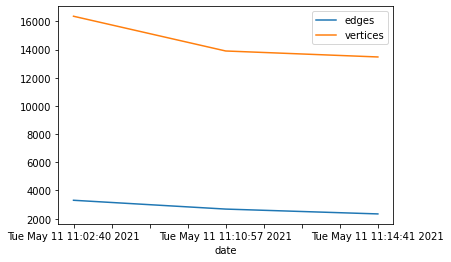

In [13]:
import matplotlib.pyplot as plt

# summarizes df
df_solution = df.pivot_table(index=['date'], aggfunc='count')
# creates new var with vertices
df_solution['vertices'] = df_solution['to'] + df_solution['from']
# consolidated edges and vertices data 
df_egd_vert = pd.DataFrame({'edges': df_solution.transaction_id, 'vertices': df_solution.vertices})
# plot
df_egd_vert.plot()
plt.savefig('egdes_vertices.png')
df_solution

Plotting

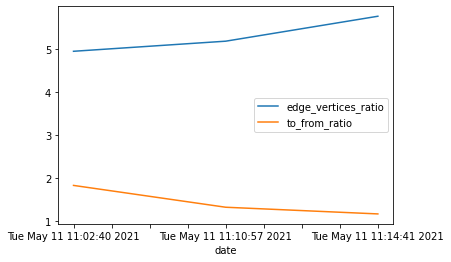

In [14]:
# creates new col with edge to vert ratio
df_solution['edge_vertices_ratio'] = df_solution['vertices'] / df_solution['transaction_id']
# creates new col with to from ratio
df_solution['to_from_ratio'] = df_solution['to'] / df_solution['from']
# creates dataframe
df_ratios = pd.DataFrame({'edge_vertices_ratio': df_solution.edge_vertices_ratio, 'to_from_ratio': df_solution.to_from_ratio})
# plot
df_ratios.plot()
plt.savefig('ratios.png')

In [16]:
# density
df_solution['density'] = (2*df_solution['transaction_id']) / (df_solution['vertices']*(df_solution['vertices']-1))

# consolidated data with ratios
df_indicators = pd.DataFrame({'edges': df_solution.transaction_id, 'vertices': df_solution.vertices,
                              'edge_vertices_ratio': df_solution.edge_vertices_ratio, 'to_from_ratio': df_solution.to_from_ratio,
                              'density': df_solution.density})
df_indicators

,edges,vertices,edge_vertices_ratio,to_from_ratio,density
date,,,,,
Tue May 11 11:02:40 2021,3306,16363,4.949486,1.834893,0.000025
Tue May 11 11:10:57 2021,2681,13898,5.183887,1.327973,0.000028
Tue May 11 11:14:41 2021,2338,13474,5.763045,1.172875,0.000026


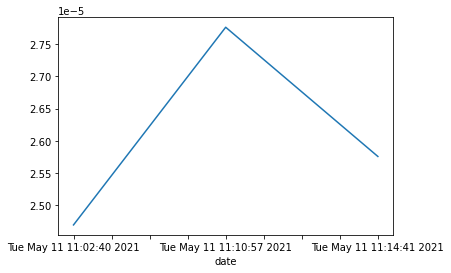

In [18]:
df_solution.density.plot()

In [ ]:
  # Next steps
    # Fix date issue - extend solution for all obs
    # Get number of blocks for first for y - maybe start with a week? maybe a day?
    # Time measures for Monthly TG and Cumulative Monthly TG
    # Network measures - clustering, density, edge-to-vertex ratio, repetition, etc.

# **TESTS**

In [ ]:
# ------------------------------------------------------------------------------------------------------------------------

# time series

# Aggregates data 
# df_solution = df.pivot_table(index=['date'], aggfunc='count')
# df_solution.plot()


# import plotly.express as px
# fig = px.histogram(df, x = 'date', y = 'transaction_id')
# fig.show()

import plotly.express as px
fig = px.line(df_indicators, x = 'date', y = 'edges')
fig.show()

In [ ]:
import plotly.express as px
fig = px.histogram(df, x = 'date', y = df['from'].notnull().sum() + df['to'].notnull().sum())
fig.show()

Create Network / Transaction graph

In [ ]:
# Network Graph
G = nx.from_pandas_edgelist(df, source='from', target='to')
nx.draw_random(G, node_size = 50)

# ------------------------------------------------------------------------------
# Jaal
  # Jaal(edge_df).plot()

          # https://towardsdatascience.com/introducing-jaal-interacting-with-network-made-easy-124173bb4fa
          # edge_df: it's a pandas dataframe with at least from and to columns, which represents the edge relationship between the entities
          # node_df: it's a pandas dataframe with at least id column which contains the unique node names     

# ------------------------------------------------------------------------------

# NetworkX         
    # https://colab.research.google.com/github/jdwittenauer/ipython-notebooks/blob/master/notebooks/libraries/NetworkX.ipynb
    # https://towardsdatascience.com/visualizing-networks-in-python-d70f4cbeb259



In [ ]:
import pyvis
from pyvis.network import network
net = Network(notebook=True)
net.from_nx(G)
net.show("---")

**BACKUP**

In [1]:
# import packages
import requests
import tabulate
import pandas as pd
import networkx as nx
import numpy as np
 
 
# 682950 - 683238: 11/05/2021 
# 683094 - initial example
 
# range block
block_range = list(range(683093, 683098))
 
r1 = 0
r2 = 1
size_block = range(r1, r2)
 
# transaction info
transaction_id = []
input_address = []
input_value = []
output_address = []
output_value = []
date = []
 
# range transaction
r3 = 0
r4 = 10
# len(txs)
size = range(r3, r4)
 
for y in size_block:
 
  # transaction link
  link_block = 'https://chain.so/api/v2/get_block/BTC/' + str(block_range[y])
 
  response = requests.get(link_block)
 
  if response.status_code == 200:
      # everything went swimmingly                                                                                                                   
      # parse the response as JSON
      content = response.json()
      
      # transaction id
      txs = content['data']['txs']
 
  for x in size:
 
    # transaction link
    link_txs = 'https://chain.so/api/v2/tx/BTC/' + str(txs[x])
 
    response = requests.get(link_txs)
 
      
    if response.status_code == 200:
          # everything went swimmingly parse the response as JSON
          content = response.json()
 
          # transaction_id
          transaction_id.append(content['data']['txid'])
          
          # input leg
          for each in content['data']['inputs']:
            input_address.append(each['address'])
            input_value.append(each['value'])
 
          # output leg
          for each in content['data']['outputs']:
            output_address.append(each['address'])
            output_value.append(each['value'])
 
          # date
          date.append(content['data']['time'])
 
          largest = max(len(transaction_id), len(input_address), len(input_value), len(output_address), len(output_value))
          
    # filling for different len
    len_transaction_id = largest - len(transaction_id)
    len_input_address = largest - len(input_address)
    len_output_address = largest - len(output_address)
    len_date = largest - len(date)
 
    corr_transaction_id = [None]*len_transaction_id
    corr_input_address = [None]*len_input_address
    corr_output_address = [None]*len_output_address
    corr_date = [None]*len_date
 
    transaction_id.extend(corr_transaction_id)
    input_address.extend(corr_input_address)
    input_value.extend(corr_input_address)
    output_address.extend(corr_output_address)
    output_value.extend(corr_output_address)
    date.extend(corr_date)
    
# as data frame 
df_01 = pd.DataFrame({'transaction_id': transaction_id, 'from': input_address, 'tt_value': input_value, 'to': output_address, 'amount': output_value, 'date': date})
 
 
#clean data
  # obmit nulldata & reindex
df= df_01[df_01.to != "nulldata"]
df.reset_index(drop=True, inplace=True)
 
 
 # fill NaN with previous data for all NaN, None
df.date = df.date.fillna(method = 'ffill')
df = df.fillna(value=np.nan)
df

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,transaction_id,from,tt_value,to,amount,date
0,5904733a3b5c0762d00fa931358b07af4c7d27272f5307...,coinbase,7.29566629,bc1qx9t2l3pyny2spqpqlye8svce70nppwtaxwdrp4,7.29566629,1.620731e+09
1,46fde81ba436974ff04118d178889f3e1e1949e1225566...,bc1qy5t8srull5qxahd8fxeek02jgufm7kl69pj9ar,0.94516086,132azVxirjmW5nQqrUHGB1jVzogHv8aWmL,0.00123653,1.620731e+09
2,NaN,NaN,NaN,3MR6fT6GT34QPMMszKDi4ALAm8cyqy2xD3,0.00284063,1.620731e+09
3,NaN,NaN,NaN,1D2Gb8EATEqS8YcMxTyi5RR5ismqQHzBsK,0.00422860,1.620731e+09
4,NaN,NaN,NaN,3AN3E6jF439iBqeyBG7CkVVWZBR88wbdNR,0.02117593,1.620731e+09
5,NaN,NaN,NaN,bc1qf00j492k6y800lr4wdtmfxsuxxnq9gvu8lex7a,0.91419917,1.620731e+09
6,431766a0a6a117f3f41777cf3a60901e633c070bb08913...,bc1qu3l4q0fcdhrucf4y658dnlf0x5404pmp3nk8kp,8.20975695,157FJp1aMEyvdYGtfQ3LHEmbvwq5o5aW2t,0.00019787,1.620731e+09
7,NaN,NaN,NaN,35GD6Byj7M3br57SHFcQYGXHVkyXHpHLc2,0.00911332,1.620731e+09
8,NaN,NaN,NaN,3PgiSaF5jvpr9VughJJWdw9yAumHdmPL7M,0.01000000,1.620731e+09
9,NaN,NaN,NaN,bc1q6q7ctzv3qxdyt2p80x83kgykkct6gkr452hht4,8.18933576,1.620731e+09
